Scatter plot of a run (True vs Predicted values) for XGBoost Regression Model

The Scatter Plot is estimated for data with and without imbued 0s, and for three different set of bins and before and after ReducedOverfitting. It also plots for data where the damaged values (target) are greater than 10.

In [ ]:
%load_ext jupyter_black

In [ ]:
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

from utils import get_clean_dataset

In [ ]:
df = get_clean_dataset()

In [2]:
#df = df[df['DAM_perc_dmg'] > 10]
#df

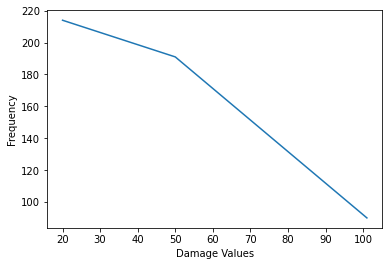

In [2]:
#The chosen bins
#bins2= [0, 1, 60, 101]
#bins2 = [0, 0.00009, 1, 10, 50, 101]
bins2= [10.0009, 20, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [3]:
print(samples_per_bin2)
print(binsP2)

[214 191  90]
[ 10.0009  20.      50.     101.    ]


In [4]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [5]:
y_input_strat=bin_index2

In [6]:
#Dropping highly correlated features (correlation value > 0.99) from X data.
features =[
    'HAZ_rainfall_Total', 
    'HAZ_rainfall_max_6h',
    'HAZ_rainfall_max_24h',
    'HAZ_v_max',
    'HAZ_v_max_3',
    'HAZ_dis_track_min',
    'GEN_landslide_per',
    'GEN_stormsurge_per',
    #'GEN_Bu_p_inSSA', 
    #'GEN_Bu_p_LS', 
    'GEN_Red_per_LSbldg',
    'GEN_Or_per_LSblg', 
    'GEN_Yel_per_LSSAb', 
    #'GEN_RED_per_SSAbldg',
    'GEN_OR_per_SSAbldg',
    'GEN_Yellow_per_LSbl',
    'TOP_mean_slope',
    'TOP_mean_elevation_m', 
    'TOP_ruggedness_stdev', 
    #'TOP_mean_ruggedness',
    #'TOP_slope_stdev', 
    'VUL_poverty_perc',
    'GEN_with_coast',
    'GEN_coast_length', 
    'VUL_Housing_Units',
    'VUL_StrongRoof_StrongWall', 
    'VUL_StrongRoof_LightWall',
    'VUL_StrongRoof_SalvageWall', 
    'VUL_LightRoof_StrongWall',
    'VUL_LightRoof_LightWall', 
    'VUL_LightRoof_SalvageWall',
    'VUL_SalvagedRoof_StrongWall',
    'VUL_SalvagedRoof_LightWall',
    'VUL_SalvagedRoof_SalvageWall', 
    'VUL_vulnerable_groups',
    'VUL_pantawid_pamilya_beneficiary'
]

X = df[features]
#display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2) 


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(6458, 31) (6458,)
(1615, 31) (1615,)


In [8]:
# create an xgboost regression model

#XGBoost
#xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, gamma=1, reg_lambda=0.1, colsample_bytree=0.8)
#xgb_model=xgb.fit(X_train, y_train)


#XGBoost Reduced Overfitting
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                   colsample_bynode=0.8, colsample_bytree=0.8, gamma=3, eta=0.01,
                   importance_type='gain', learning_rate=0.1, max_delta_step=0,
                   max_depth=4, min_child_weight=1, missing=1, n_estimators=100, early_stopping_rounds=10,
                   n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
                   reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                   silent=None, subsample=0.8, verbosity=1, eval_metric=["rmse", "logloss"]
                  )

    
eval_set = [(X_test, y_test)]
xgb_model=xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)


In [9]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     174.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:11:48   Log-Likelihood:                -21515.
No. Observations:                6458   AIC:                         4.309e+04
Df Residuals:                    6426   BIC:                         4.331e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4715      0.085     29.249      0.0

In [10]:
y_pred_train = xgb.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mx_train = max_error(y_train, y_pred_train)
me_train = (y_pred_train - y_train).sum()/len(y_train)

y_pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mx = max_error(y_test, y_pred)
me = (y_pred - y_test).sum()/len(y_test)

print('----- Test  ------')
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Max error: {mx:.2f}')
print(f"Average Error: {me:.2f}")

print('---- Training -----')
print(f'Mean absolute error: {mae_train:.2f}')
print(f'Mean squared error: {mse_train:.2f}')
print(f'Root mean squared error: {rmse_train:.2f}')
print(f'Max error: {mx_train:.2f}')
print(f"Average Error: {me_train:.2f}")

----- Test  ------
Mean absolute error: 1.89
Mean squared error: 31.39
Root mean squared error: 5.60
Max error: 90.21
Average Error: 0.16
---- Training -----
Mean absolute error: 1.60
Mean squared error: 20.46
Root mean squared error: 4.52
Max error: 81.04
Average Error: -0.03


plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, c='crimson')


p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=10)
plt.ylabel('Predicted Values', fontsize=10)
plt.title('True vs Predicted damaged values')
plt.axis('equal')
plt.show()

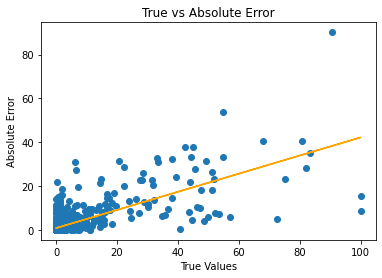

In [11]:
#Draw Scatter plot 
x = y_test
y = abs(y_pred - y_test)

plt.scatter(x, y, cmap='viridis')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='orange')


plt.xlabel('True Values', fontsize=10)
plt.ylabel('Absolute Error', fontsize=10)
plt.title('True vs Absolute Error')
plt.show()